In [53]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#Directly Load Model
from pathlib import PurePath
import tensorflow as tf
ModelBlock5 = tf.keras.models.load_model(str(PurePath('Model','Block5_Model')), compile = False)

Image_sample = tf.zeros([384,384,3])
#Make it 4D Tensor
Image_sample_input = tf.expand_dims(Image_sample, 0)
Out_image = ModelBlock5(Image_sample_input)
print(Out_image)



tf.Tensor(
[[[[0.25363714 0.27225128 0.18778084]
   [0.23852514 0.25642765 0.17319235]
   [0.1812127  0.2544927  0.15840526]
   ...
   [0.13140519 0.13352211 0.08820476]
   [0.16942532 0.06585877 0.01275396]
   [0.12769338 0.20358719 0.1209075 ]]

  [[0.306194   0.3279472  0.24048787]
   [0.24980102 0.26248762 0.18839908]
   [0.227339   0.21802898 0.20536718]
   ...
   [0.04027627 0.22851183 0.09719929]
   [0.20763001 0.09454001 0.12148115]
   [0.11754468 0.18129045 0.05649931]]

  [[0.24751894 0.2852369  0.21910556]
   [0.20745876 0.22057149 0.1499666 ]
   [0.281523   0.2186363  0.20300779]
   ...
   [0.17136073 0.25682712 0.07194652]
   [0.10839508 0.16333279 0.09038769]
   [0.12609844 0.2556428  0.0639099 ]]

  ...

  [[0.3276516  0.368524   0.30485547]
   [0.24425758 0.30018517 0.23633379]
   [0.28335565 0.33853245 0.2796687 ]
   ...
   [0.2665866  0.26259083 0.24436218]
   [0.3386051  0.2706881  0.16607471]
   [0.2766862  0.305955   0.24244756]]

  [[0.33961213 0.35710084 0.328969

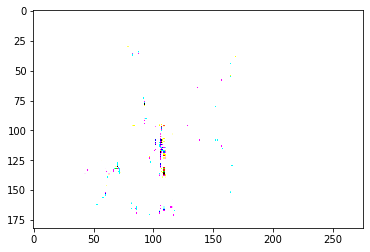

In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import tensorflow as tf
from pathlib import PurePath
import sys

from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import numpy as np


class VGG19AE(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AE, self).__init__()
        #Load Model
        ModelBlock5 = tf.keras.models.load_model(str(PurePath(files_path, 'Block5_Model')), compile = False)
        #Get Each SubModel
        self.E5 = ModelBlock5.layers[0]
        self.D5 = ModelBlock5.layers[1]
        self.O5 = ModelBlock5.layers[2]
        ModelBlock4 = tf.keras.models.load_model(str(PurePath(files_path, 'Block4_Model')), compile = False)
        self.E4 = ModelBlock4.layers[0]
        self.D4 = ModelBlock4.layers[1]
        self.O4 = ModelBlock4.layers[2]
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0]
        self.D3 = ModelBlock3.layers[1]
        self.O3 = ModelBlock3.layers[2]
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0]
        self.D2 = ModelBlock2.layers[1]
        self.O2 = ModelBlock2.layers[2]
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0]
        self.O1 = ModelBlock1.layers[1]

    def call(self, Image, training  = False):
        # Input should be 4D Tensor
        xo, I2 = Image
        x = self.E2(xo)
        style = self.E2(I2)
        #Add WCT Here
        #x = wct(x,style)
        # x = self.wct(self,x,style)
        x = self.D2(x)
        x = self.O2(x)
        # Block 1 Donot have decoder because it don't contain Pooling and there are only one Conv layer.
        x = self.E1(x)
        x = self.O1(x)
        return tf.clip_by_value(tf.squeeze(x), 0, 1)
AE = VGG19AE('Model')


img_c = image.load_img("image/elephant.png")
img_c = image.img_to_array(img_c)
img_c_shape = img_c.shape


img_s = image.load_img("image/star.jpg")
img_s = image.img_to_array(img_s)
img_s_shape = img_s.shape



#Make it 4D Tensor
Image_sample_input = (tf.expand_dims(img_c, 0), tf.expand_dims(img_s, 0))
Out_image = AE(Image_sample_input)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(Out_image)
plt.show()

#print(Out_image)

In [3]:
def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py
       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)

